In [17]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import skimage.io

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [18]:
class ViolinConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "violin"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shape

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 160/8

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ViolinConfig()
config.display()

import warnings
import re

warnings.filterwarnings('ignore', category=FutureWarning, message=re.escape("Input image dtype is bool. Interpolation is not defined with bool data type."))



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

In [19]:
class InferenceConfig(ViolinConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = './logs/violin20241109T1129/mask_rcnn_violin_0050.h5'

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./logs/violin20241109T1129/mask_rcnn_violin_0050.h5
Re-starting from epoch 50


In [20]:
class ViolinDataset(utils.Dataset):
    def load_violins(self, dataset_dir, json_path):
        # Ajouter la classe
        self.add_class("violin", 1, "violin")  # 1 est l'ID de la classe "violon"

        # Charger les annotations depuis le fichier JSON
        with open(json_path) as f:
            annotations = json.load(f)
        #print(annotations)
        # Parcourir les annotations pour ajouter les images
        for annotation in annotations:
            #filename = annotation['filename']
            filename = annotations[annotation]['filename']
            #width = annotations[annotation]['width']
            #height = annotations[annotation]['height']
            size = annotations[annotation]['size']
            polygons = annotations[annotation]['regions']  # Cela peut être des masques ou des boîtes englobantes

            image_path = os.path.join(dataset_dir, filename)
            self.add_image(
                "violin",
                image_id=filename,
                path=image_path,
                size=size,
                polygons=polygons
            )

    def load_mask(self, image_id):
        """
        Charge les masques de segmentation pour une image donnée.
        Chaque objet est représenté par un polygone (polyline).
        """
        # Obtenir les informations de l'image à partir de image_id
        info = self.image_info[image_id]
        
        # Charger l'image pour obtenir sa taille
        image = self.load_image(image_id)
        height, width = image.shape[:2]
        
        # Initialiser un masque vide de taille (hauteur, largeur, nombre de polygones)
        mask = np.zeros((height, width, len(info['polygons'])), dtype=np.uint8)
        # Liste des ID de classes pour les objets
        class_ids = []
        # Parcourir les régions annotées (polygones)
        for i, region in enumerate(info['polygons']):
            
            # Extraire les coordonnées du polygone
            shape_attr = region['shape_attributes']
            all_points_x = shape_attr['all_points_x']
            all_points_y = shape_attr['all_points_y']
            # Convertir les coordonnées du polygone en indices de pixels
            poly_x, poly_y = skimage.draw.polygon(all_points_y, all_points_x)
            
            # Assurer que les indices sont dans les limites de l'image
            poly_x = np.clip(poly_x, 0, height - 1)
            poly_y = np.clip(poly_y, 0, width - 1)
            # Remplir le masque pour cette instance de polygone
            mask[poly_x, poly_y, i] = 1
            # Ajouter l'ID de la classe (par exemple, "violin")
            class_ids.append(self.class_names.index(region['region_attributes']['type']))

        # Retourner le masque et les ID des classes
        return mask, np.array(class_ids)

# Validation dataset
dataset_val = ViolinDataset()
dataset_val.load_violins('./test', './test/via_project_8Nov2024_22h27m_json.json')
dataset_val.prepare()

In [21]:
# # Compute VOC-Style mAP @ IoU=0.5
# # Running on all validation images
# image_ids = dataset_val.image_ids
# APs = []

# for image_id in image_ids:
#     # Load image and ground truth data
#     image, image_meta, gt_class_id, gt_bbox, gt_mask = \
#         modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
    
#     # Skip images without ground truth objects (e.g., no violins)
#     if len(gt_class_id) == 0:
#         continue  # Skip this image and move to the next one

#     # Preprocess the image for the model
#     molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    
#     # Run object detection
#     results = model.detect([image], verbose=0)
#     r = results[0]
    
#     # Compute AP
#     AP, precisions, recalls, overlaps = \
#         utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                          r["rois"], r["class_ids"], r["scores"], r['masks'])
    
#     APs.append(AP)

# # Compute the mean Average Precision (mAP)
# if len(APs) > 0:
#     mean_AP = np.mean(APs)
#     print("mAP: ", mean_AP)
# else:
#     print("No valid images with ground truth objects to calculate mAP.")


mAP:  0.7323232323232324
Precision:  0.9347826086956522
Recall:  1.0
F1-Score:  0.9662921348314606


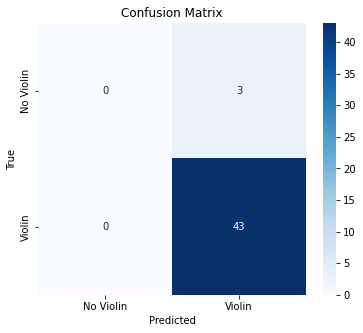

False positive : 3


In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on all validation images
image_ids = dataset_val.image_ids

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialiser les compteurs pour le calcul de la matrice de confusion
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0
APs = []

# Parcourir toutes les images de validation
for image_id in image_ids:
    # Charger l'image et les données de vérité terrain
    image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

    # Exécuter la détection d'objets
    results = model.detect([image], verbose=0)
    r = results[0]

    # Vérifier si l'image contient des violons dans les données de vérité terrain
    if len(gt_class_id) == 0:
        # Cas où il n'y a pas de violon dans l'image (ground truth vide)
        if len(r['class_ids']) > 0:
            # Si le modèle détecte un violon alors qu'il n'y en a pas, c'est un faux positif
            false_positives += len(r['class_ids'])
        else:
            # Si le modèle ne détecte aucun violon, c'est un vrai négatif
            true_negatives += 1
    else:
        # Cas où il y a des violons dans l'image
        # Calculer les AP pour ces images
        AP, precisions, recalls, overlaps = \
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)

        # Calculer les True Positives, False Positives et False Negatives
        for gt_id in gt_class_id:
            if gt_id in r["class_ids"]:
                true_positives += 1  # Détection correcte
            else:
                false_negatives += 1  # Le modèle n'a pas détecté un violon présent

        for pred_id in r["class_ids"]:
            if pred_id not in gt_class_id:
                false_positives += 1  # Détection incorrecte

# Calculer la moyenne des AP (mAP)
if len(APs) > 0:
    mean_AP = np.mean(APs)
    print("mAP: ", mean_AP)
else:
    print("No valid images with ground truth objects to calculate mAP.")

# Calculer la précision, le rappel, la F1-score et les vrais négatifs
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)

# Créer la matrice de confusion
conf_matrix = np.array([
    [true_negatives, false_positives],
    [false_negatives, true_positives]
])

# Afficher la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Violin", "Violin"], yticklabels=["No Violin", "Violin"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()